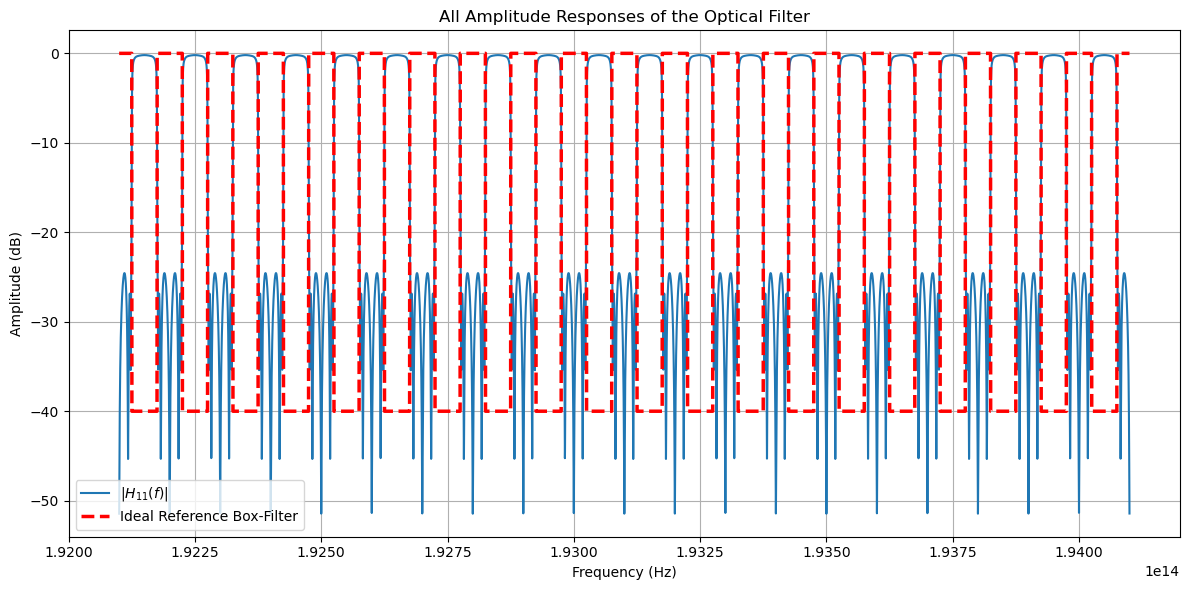

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):

    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db

    return reference_signal

# 基础参数
kr = 0.5
kl = 0.5
k1 = 0.8673
k2 = 0.09
k3 = 0.393

phi1 = 0.5 * 2 * np.pi
phi2 = 0.5 * 2 * np.pi
phi3 = 0.5 * 2 * np.pi
phid = 0
t = 0.979888
fFSR = 100e9  # 100 GHz
s = 10

# 定义耦合矩阵
j = 1j
H1 = np.array([[np.sqrt(1 - kr), -j * np.sqrt(kr)],
               [-j * np.sqrt(kr), np.sqrt(1 - kr)]])

H3 = np.array([[np.sqrt(1 - kl), -j * np.sqrt(kl)],
               [-j * np.sqrt(kl), np.sqrt(1 - kl)]])

# 频率向量初始化
w1 = -20 * np.pi
w2 = 20 * np.pi
dw = 0.006285
w_range = np.arange(w1, w2, dw)
len_w = len(w_range)

# 定义 Au(w) 和 Al(w)
def Au(w):
    e = np.exp(-j * w)
    term1 = (np.sqrt(1 - k1) - t**2 * e**2 * np.exp(-j * phi1)) / (1 - np.sqrt(1 - k1) * t**2 * e**2 * np.exp(-j * phi1))
    term2 = (np.sqrt(1 - k2) - t**2 * e**2 * np.exp(-j * phi2)) / (1 - np.sqrt(1 - k2) * t**2 * e**2 * np.exp(-j * phi2))
    return term1 * term2

def Al(w):
    e = np.exp(-j * w)
    term = (np.sqrt(1 - k3) - t**2 * e**2 * np.exp(-j * phi3)) / (1 - np.sqrt(1 - k3) * t**2 * e**2 * np.exp(-j * phi3))
    return term * t * e * np.exp(-j * phid)

# 初始化输出
H11 = np.zeros(len_w, dtype=complex)
H12 = np.zeros(len_w, dtype=complex)
H21 = np.zeros(len_w, dtype=complex)
H22 = np.zeros(len_w, dtype=complex)

# 主循环
for i, w in enumerate(w_range):
    H2 = np.array([[Au(w), 0],
                   [0, Al(w)]])
    H = H1 @ H2 @ H3
    H11[i] = H[0, 0]
    H12[i] = H[0, 1]
    H21[i] = H[1, 0]
    H22[i] = H[1, 1]

# 频率向量对应光学频率（单位：Hz）
frequency_f = np.linspace(193.1e12 - s * fFSR, 193.1e12 + s * fFSR, len_w)

# 幅度响应 (dB)
amplitude_H11 = 20 * np.log10(np.abs(H11))
amplitude_H12 = 20 * np.log10(np.abs(H12))
amplitude_H21 = 20 * np.log10(np.abs(H21))
amplitude_H22 = 20 * np.log10(np.abs(H22))

# 定义理想方波滤波器的参数
ref_center_freq = 193.1e12            # 中心频率
ref_fsr = 100e9                       # 周期 (FSR)
ref_bandwidth = 50e9                  # 通带带宽
ref_passband_db = 0                   # 通带电平 (dB)
ref_stopband_db = -40                 # 阻带电平 (dB)

# 生成参考信号
reference_amplitude = create_reference_box_filter(
    frequency_array=frequency_f,
    center_freq=ref_center_freq,
    fsr=ref_fsr,
    bandwidth=ref_bandwidth,
    passband_level_db=ref_passband_db,
    stopband_level_db=ref_stopband_db
)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(frequency_f, amplitude_H11, label=r'$|H_{11}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H12, label=r'$|H_{12}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H21, label=r'$|H_{21}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H22, label=r'$|H_{22}(f)|$', linewidth=1.5)
plt.plot(frequency_f, reference_amplitude, label='Ideal Reference Box-Filter', linestyle='--', linewidth=2.5, color='red')

plt.title('All Amplitude Responses of the Optical Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Mean Squared Error (MSE) Loss: 14.3723


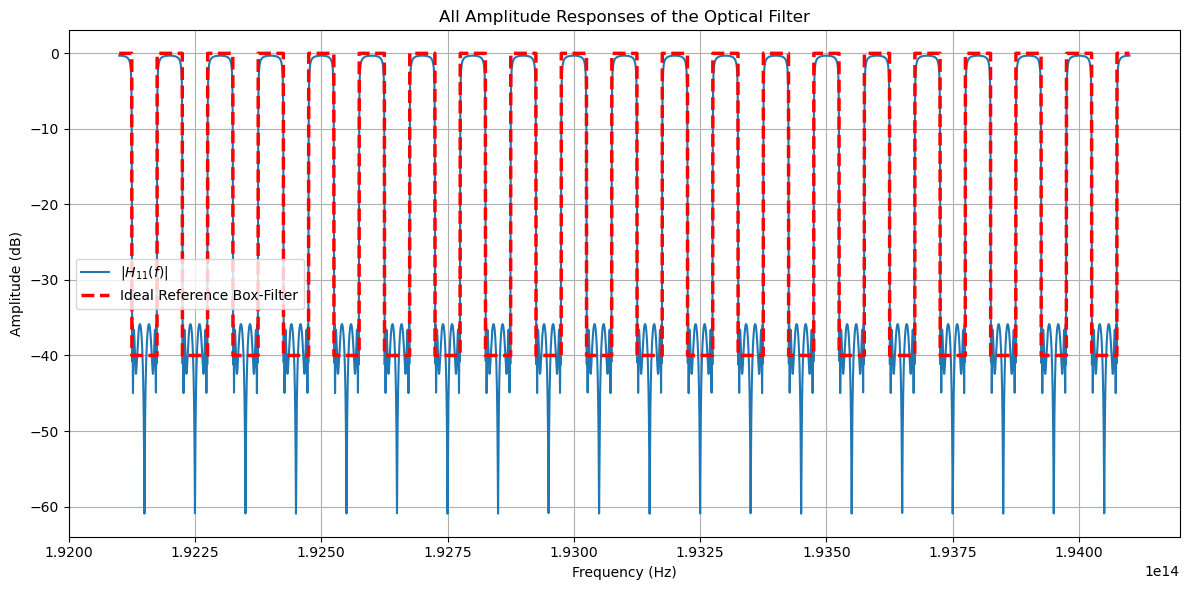

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):

    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db

    return reference_signal


f_center = 193.1e12  # 中心频率 (Hz)
FSR = 100e9          # 自由光谱范围 (Hz), 100 GHz

theta_i = np.pi / 2
theta_o = np.pi / 2

phi_t = 0.0
phi_b = 0.0 

Hi = tunable_mzi_in(theta_i)
Hp = phase_shifter_matrix(phi_t, phi_b)

H1 = Hi @ Hp

H3 = tunable_mzi_out(theta_o)

t = 0.979888

ku1 = 0.9668
ku2 = 0.4233
ku3 = 0.0537
kl1 = 0.184
kl2 = 0.7543


Au = lambda w: mrr_transfer_function(w, t, ku1, phi_offset=np.pi) * mrr_transfer_function(w, t, ku2, phi_offset=np.pi) * mrr_transfer_function(w, t, ku3, phi_offset=np.pi)
Al = lambda w: mrr_transfer_function(w, t, kl1, phi_offset=np.pi) * mrr_transfer_function(w, t, kl2, phi_offset=np.pi) * delay_line(w, t, delay=1.0, phi_c=0.0)

H2 = np.array([[Au, 0],
                [0, Al]])

w1 = -20 * np.pi
w2 = 20 * np.pi
dw = 0.006285
w_range = np.arange(w1, w2, dw)
len_w = len(w_range)

s=10

H11 = np.zeros(len_w, dtype=complex)
H12 = np.zeros(len_w, dtype=complex)
H21 = np.zeros(len_w, dtype=complex)
H22 = np.zeros(len_w, dtype=complex)

# 主循环
for i, w in enumerate(w_range):
    H2 = np.array([[Au(w), 0],
                   [0, Al(w)]])
    H = H1 @ H2 @ H3
    H11[i] = H[0, 0]
    H12[i] = H[0, 1]
    H21[i] = H[1, 0]
    H22[i] = H[1, 1]

# 频率向量对应光学频率（单位：Hz）
frequency_f = np.linspace(f_center - s * FSR, f_center + s * FSR, len_w)

# 幅度响应 (dB)
amplitude_H11 = 20 * np.log10(np.abs(H11))
amplitude_H12 = 20 * np.log10(np.abs(H12))
amplitude_H21 = 20 * np.log10(np.abs(H21))
amplitude_H22 = 20 * np.log10(np.abs(H22))

# 定义理想方波滤波器的参数
ref_center_freq = 193.1e12            # 中心频率
ref_fsr = 100e9                       # 周期 (FSR)
ref_bandwidth = 50e9                  # 通带带宽
ref_passband_db = 0                   # 通带电平 (dB)
ref_stopband_db = -40                 # 阻带电平 (dB)

# 生成参考信号
reference_amplitude = create_reference_box_filter(
    frequency_array=frequency_f,
    center_freq=ref_center_freq,
    fsr=ref_fsr,
    bandwidth=ref_bandwidth,
    passband_level_db=ref_passband_db,
    stopband_level_db=ref_stopband_db
)

mse_loss = np.mean((amplitude_H11 - reference_amplitude)**2)
print(f'Mean Squared Error (MSE) Loss: {mse_loss:.4f}')

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(frequency_f, amplitude_H11, label=r'$|H_{11}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H12, label=r'$|H_{12}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H21, label=r'$|H_{21}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H22, label=r'$|H_{22}(f)|$', linewidth=1.5)
plt.plot(frequency_f, reference_amplitude, label='Ideal Reference Box-Filter', linestyle='--', linewidth=2.5, color='red')

plt.title('All Amplitude Responses of the Optical Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



开始使用差分进化算法寻找最优参数...
differential_evolution step 1: f(x)= 62.117692428004155
differential_evolution step 2: f(x)= 62.117692428004155
differential_evolution step 3: f(x)= 60.899539997178216
differential_evolution step 4: f(x)= 60.899539997178216
differential_evolution step 5: f(x)= 60.899539997178216
differential_evolution step 6: f(x)= 60.899539997178216
differential_evolution step 7: f(x)= 60.899539997178216
differential_evolution step 8: f(x)= 60.899539997178216
differential_evolution step 9: f(x)= 60.208859984025324
differential_evolution step 10: f(x)= 55.80364058701755
differential_evolution step 11: f(x)= 55.80364058701755
differential_evolution step 12: f(x)= 39.08107108959039
differential_evolution step 13: f(x)= 39.08107108959039
differential_evolution step 14: f(x)= 39.08107108959039
differential_evolution step 15: f(x)= 32.83261533974259
differential_evolution step 16: f(x)= 30.90903647716675
differential_evolution step 17: f(x)= 30.90903647716675
differential_evolution step 

/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/3160674283.py:162: UserWarning: Glyph 26524 (\N{CJK UNIFIED I

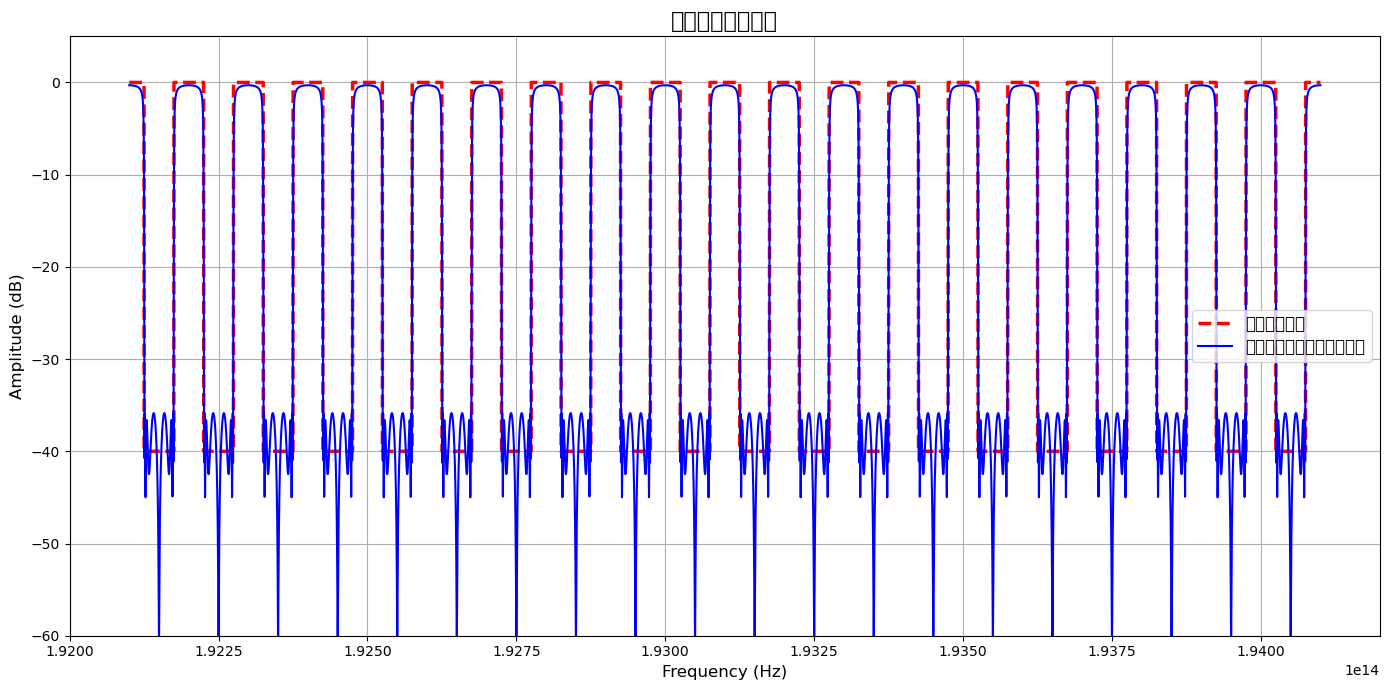

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):

    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db

    return reference_signal

def optical_simulation(params, t, w_range, H1, H3):
    ku1, ku2, ku3, kl1, kl2 = params
    len_w = len(w_range)

    Au = mrr_transfer_function(w_range, t, ku1, phi_offset=np.pi) * \
         mrr_transfer_function(w_range, t, ku2, phi_offset=np.pi) * \
         mrr_transfer_function(w_range, t, ku3, phi_offset=np.pi)
         
    Al = mrr_transfer_function(w_range, t, kl1, phi_offset=np.pi) * \
         mrr_transfer_function(w_range, t, kl2, phi_offset=np.pi) * \
         delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0] = Au
    H2_stack[:, 1, 1] = Al

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    return 20 * np.log10(np.abs(H11))

def objective_function(params, target_spectrum_db, t, w_range, H1, H3):

    # 将接收到的参数传递给仿真函数
    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3)
    
    # 直接与传入的目标频谱进行比较
    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)
    return mse_loss

if __name__ == "__main__":
    
    # 物理和仿真常量
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 预计算频率数组
    w1 = -20 * np.pi
    w2 = 20 * np.pi
    dw = 0.006285
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    frequency_f = np.linspace(f_center - s * fsr, f_center + s * fsr, len_w)
    
    # 预计算不变的矩阵 H1 和 H3
    Hi = tunable_mzi_in(theta_i)
    Hp = phase_shifter_matrix(phi_t, phi_b)
    H1 = Hi @ Hp
    H3 = tunable_mzi_out(theta_o)
    
    # 预计算理想目标频谱
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_f,
        center_freq=f_center,
        fsr=fsr,
        bandwidth=50e9,
        passband_level_db=0,
        stopband_level_db=-40
    )
    
    # 待优化参数的取值范围
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

    # 将所有需要传递给目标函数的固定参数打包成一个元组
    args_for_optimizer = (target_spectrum, t, w_range, H1, H3)

    # 运行差分进化优化器
    print("="*50)
    print("开始使用差分进化算法寻找最优参数...")
    print("="*50)
    
    start_time = time.time()
    
    result = differential_evolution(
        objective_function, 
        bounds, 
        args=args_for_optimizer, 
        maxiter=300,
        popsize=20,
        disp=True,
        workers=-1 
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")

    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 最低损失值 (MSE): {result.fun}")
    best_params = result.x
    print(f"  - 找到的最佳参数 [ku1, ku2, ku3, kl1, kl2]:\n    {np.round(best_params, 4)}")
    print("="*50)
    
    # 进行最终验证
    print("\n正在使用找到的最佳参数进行最终效果验证...")
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3)

    # 绘图对比
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f, target_spectrum, 'r--', lw=2.5, label='理想方波目标')
    plt.plot(frequency_f, final_spectrum_db, 'b-', lw=1.5, label='优化后参数得到的最终响应')
    plt.title('差分进化优化结果', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Amplitude (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

开始优化 3 个参数 (2个上臂环, 1个下臂环)...
differential_evolution step 1: f(x)= 145.21973319037022
differential_evolution step 2: f(x)= 115.69718399186279
differential_evolution step 3: f(x)= 77.59961779548266
differential_evolution step 4: f(x)= 77.59961779548266
differential_evolution step 5: f(x)= 77.59961779548266
differential_evolution step 6: f(x)= 73.74555564954115
differential_evolution step 7: f(x)= 65.9921723857098
differential_evolution step 8: f(x)= 65.9921723857098
differential_evolution step 9: f(x)= 50.66280385123755
differential_evolution step 10: f(x)= 50.66280385123755
differential_evolution step 11: f(x)= 40.28031475280774
differential_evolution step 12: f(x)= 40.28031475280774
differential_evolution step 13: f(x)= 39.372401271033965
differential_evolution step 14: f(x)= 35.06809975460702
differential_evolution step 15: f(x)= 35.06809975460702
differential_evolution step 16: f(x)= 35.06809975460702
differential_evolution step 17: f(x)= 35.06809975460702
differential_evolution step

/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/27886444.py:169: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}

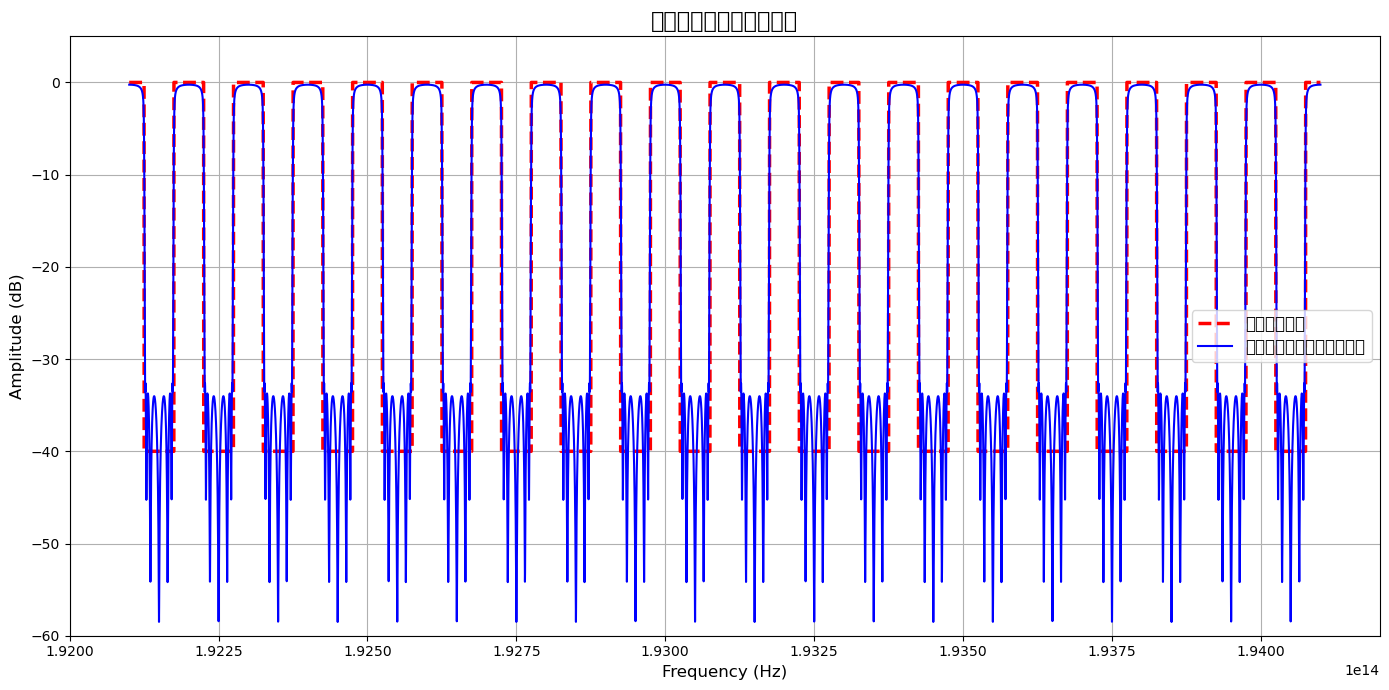

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):
    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db
    return reference_signal


def optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl):

    ku_params = params[:n_ku]
    kl_params = params[n_ku:]
    
    len_w = len(w_range)

    # 计算上臂 Au 的响应
    Au_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in ku_params]
    Au = np.prod(Au_mrr_responses, axis=0)
    
    # 计算下臂 Al 的响应
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in kl_params]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0

    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0] = Au
    H2_stack[:, 1, 1] = Al

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    return 20 * np.log10(np.abs(H11))

def objective_function(params, target_spectrum_db, t, w_range, H1, H3, n_ku, m_kl):

    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl)

    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)

    return mse_loss

if __name__ == "__main__":
    
    n_ku = 2  # 上臂的微环数量
    m_kl = 1  # 下臂的微环数量
    
    # 物理和仿真常量
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 预计算频率数组
    w1 = -20 * np.pi
    w2 = 20 * np.pi
    dw = 0.006285
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    frequency_f = np.linspace(f_center - s * fsr, f_center + s * fsr, len_w)
    
    # 预计算不变的矩阵 H1 和 H3
    Hi = tunable_mzi_in(theta_i)
    Hp = phase_shifter_matrix(phi_t, phi_b)
    H1 = Hi @ Hp
    H3 = tunable_mzi_out(theta_o)
    
    # 预计算理想目标频谱
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_f,
        center_freq=f_center,
        fsr=fsr,
        bandwidth=50e9,
        passband_level_db=0,
        stopband_level_db=-40
    )

    
    total_params = n_ku + m_kl
    bounds = [(0, 1)] * total_params

    args_for_optimizer = (target_spectrum, t, w_range, H1, H3, n_ku, m_kl)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始优化 {total_params} 个参数 ({n_ku}个上臂环, {m_kl}个下臂环)...")
    print("="*50)
    
    start_time = time.time()
    
    result = differential_evolution(
        objective_function, 
        bounds, 
        args=args_for_optimizer, 
        maxiter=300,
        popsize=20,
        disp=True,
        workers=-1 
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    
    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 最低损失值 (MSE): {result.fun}")
    best_params = result.x
    
    print(f"  - 找到的最佳参数 ({total_params}个):")
    for i in range(n_ku):
        print(f"    ku{i+1} = {best_params[i]:.4f}")
    for i in range(m_kl):
        print(f"    kl{i+1} = {best_params[n_ku + i]:.4f}")
    print("="*50)
    
    # 使用找到的最佳参数进行最终验证
    print("\n正在使用找到的最佳参数进行最终效果验证...")
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3, n_ku, m_kl)

    # 绘图对比
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f, target_spectrum, 'r--', lw=2.5, label='理想方波目标')
    plt.plot(frequency_f, final_spectrum_db, 'b-', lw=1.5, label='优化后参数得到的最终响应')
    plt.title('通用化差分进化优化结果', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Amplitude (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

开始优化 5 个参数 (3个上臂环, 2个下臂环)...


differential_evolution step 1: f(x)= 178.8098619099252
differential_evolution step 2: f(x)= 164.3216906898774
differential_evolution step 3: f(x)= 160.86183591657823
differential_evolution step 4: f(x)= 160.86183591657823
differential_evolution step 5: f(x)= 160.86183591657823
differential_evolution step 6: f(x)= 160.86183591657823
differential_evolution step 7: f(x)= 160.86183591657823
differential_evolution step 8: f(x)= 160.86183591657823
differential_evolution step 9: f(x)= 160.86183591657823
differential_evolution step 10: f(x)= 160.86183591657823
differential_evolution step 11: f(x)= 160.86183591657823
differential_evolution step 12: f(x)= 144.65588828333003
differential_evolution step 13: f(x)= 144.65588828333003
differential_evolution step 14: f(x)= 144.65588828333003
differential_evolution step 15: f(x)= 144.65588828333003
differential_evolution step 16: f(x)= 138.39275147797383
differential_evolution step 17: f(x)= 138.39275147797383
differential_evolution step 18: f(x)= 138.

/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_90396/143830705.py:184: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAP

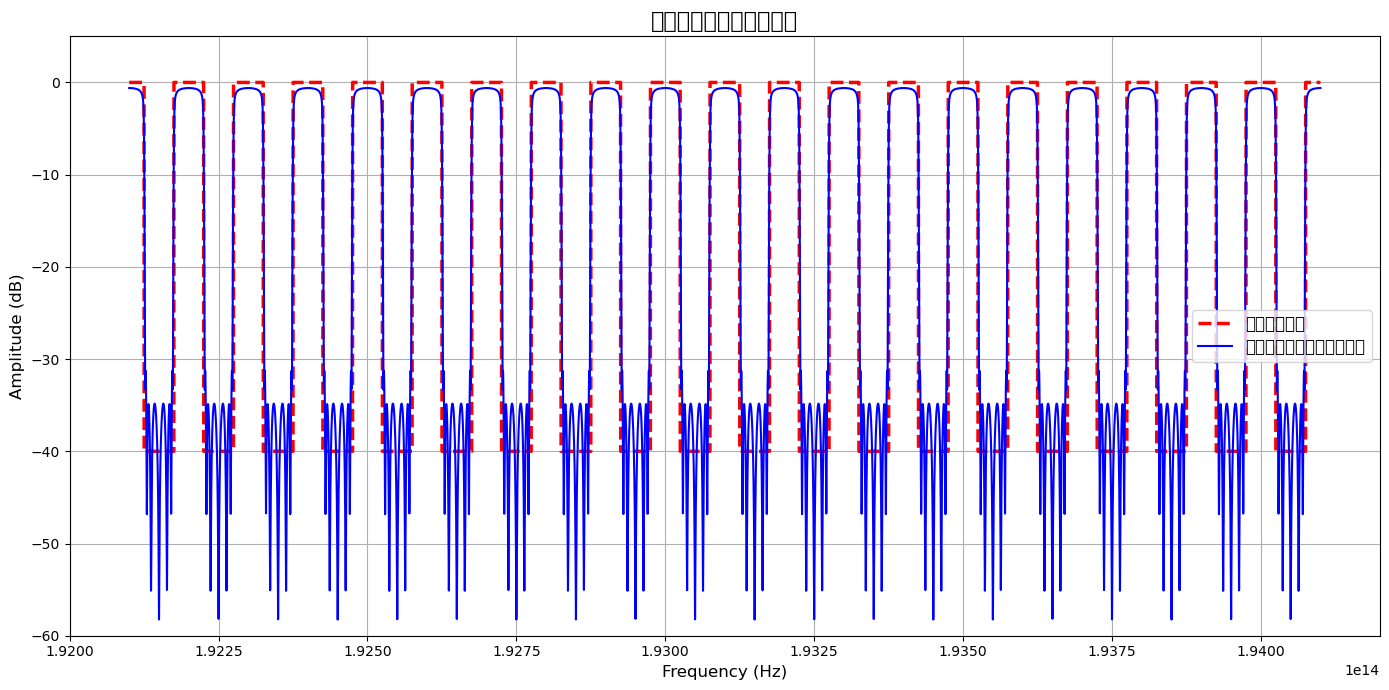

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):
    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db
    return reference_signal


def optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl):

    ku_params = params[:n_ku]
    kl_params = params[n_ku:]
    
    len_w = len(w_range)

    # 计算上臂 Au 的响应
    Au_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in ku_params]
    Au = np.prod(Au_mrr_responses, axis=0)
    
    # 计算下臂 Al 的响应
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in kl_params]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0

    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0] = Au
    H2_stack[:, 1, 1] = Al

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    return 20 * np.log10(np.abs(H11))

def objective_function(params, target_spectrum_db, frequency_f, t, w_range, H1, H3, n_ku, m_kl):
    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl)
    

    # 定义权重参数
    passband_weight = 100.0  # 通带权重
    stopband_weight = 1.0    # 阻带权重

    # 创建一个与频谱等长的权重数组，默认填充为阻带权重
    weights = np.full_like(frequency_f, stopband_weight)

    # 找到通带区域的索引，并为它们分配更高的权重
    # 我们借用 target_spectrum 的结构来识别通带
    # target_spectrum 中值为0dB的点就是通带
    passband_indices = np.where(target_spectrum_db == 0)
    weights[passband_indices] = passband_weight
    
    # 计算加权均方误差
    # 误差的平方先乘以对应的权重，再求平均
    weighted_mse_loss = np.mean(weights * (simulated_spectrum - target_spectrum_db)**2)
    
    return weighted_mse_loss

if __name__ == "__main__":
    
    n_ku = 3  # 上臂的微环数量
    m_kl = 2  # 下臂的微环数量
    
    # 物理和仿真常量
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 预计算频率数组
    w1 = -20 * np.pi
    w2 = 20 * np.pi
    dw = 0.006285
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    frequency_f = np.linspace(f_center - s * fsr, f_center + s * fsr, len_w)
    
    # 预计算不变的矩阵 H1 和 H3
    Hi = tunable_mzi_in(theta_i)
    Hp = phase_shifter_matrix(phi_t, phi_b)
    H1 = Hi @ Hp
    H3 = tunable_mzi_out(theta_o)
    
    # 预计算理想目标频谱
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_f,
        center_freq=f_center,
        fsr=fsr,
        bandwidth=50e9,
        passband_level_db=0,
        stopband_level_db=-40
    )

    
    total_params = n_ku + m_kl
    bounds = [(0, 1)] * total_params

    args_for_optimizer = (target_spectrum, frequency_f, t, w_range, H1, H3, n_ku, m_kl)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始优化 {total_params} 个参数 ({n_ku}个上臂环, {m_kl}个下臂环)...")
    print("="*50)
    
    start_time = time.time()
    
    result = differential_evolution(
        objective_function, 
        bounds, 
        args=args_for_optimizer, 
        maxiter=300,
        popsize=20,
        disp=True,
        workers=-1 
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    
    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 最低损失值 (加权MSE): {result.fun}")
    best_params = result.x
    
    print(f"  - 找到的最佳参数 ({total_params}个):")
    for i in range(n_ku):
        print(f"    ku{i+1} = {best_params[i]:.4f}")
    for i in range(m_kl):
        print(f"    kl{i+1} = {best_params[n_ku + i]:.4f}")
    print("="*50)
    
    # 使用找到的最佳参数进行最终验证
    print("\n正在使用找到的最佳参数进行最终效果验证...")
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3, n_ku, m_kl)

    # 绘图对比
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f, target_spectrum, 'r--', lw=2.5, label='理想方波目标')
    plt.plot(frequency_f, final_spectrum_db, 'b-', lw=1.5, label='优化后参数得到的最终响应')
    plt.title('通用化差分进化优化结果', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Amplitude (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

开始使用 JAX + L-BFGS-B 梯度优化算法 (3个参数)...

优化完成！总耗时: 1.17 秒

优化结果详情:
  - 最终状态: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  - 最低损失值 (MSE): 0.009179101325571537
  - 找到的最佳参数:
    ku1 = 0.2158
    ku2 = 0.9035
    kl1 = 0.6113


/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 26799 (\N{CJK UNIFIED IDEOGRAPH-68AF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1822/1834765338.py:170: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAP

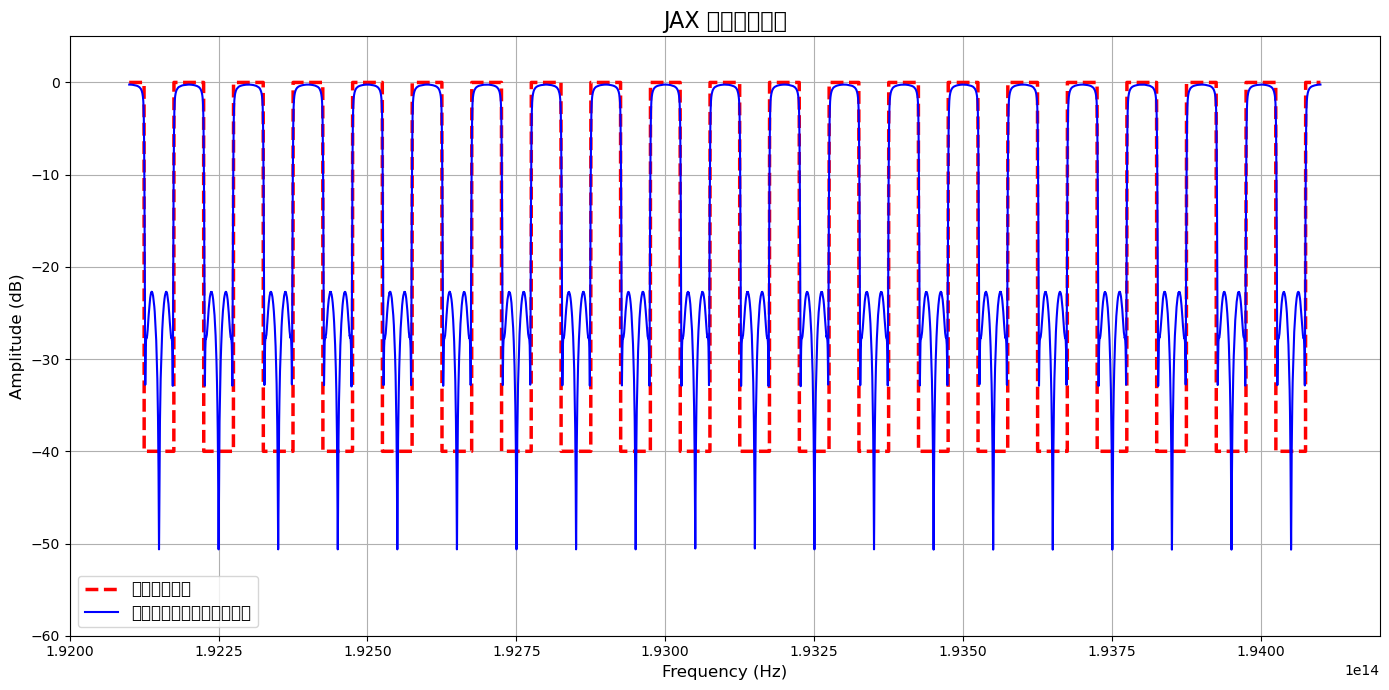

最终的均方误差 (MSE) 在 dB 级别: 110.1750


In [9]:
import numpy as np
import jax
import jax.numpy as jnp 
from jax import jit, grad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * jnp.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = jnp.array([[jnp.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * jnp.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = jnp.array([[jnp.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return jnp.array([[jnp.exp(-j * phi_t), 0], [0, jnp.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = jnp.sqrt(1 - k) - t**2 * jnp.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * jnp.sqrt(1 - k) * jnp.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * jnp.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level, stopband_level):
    reference_signal = np.full_like(frequency_array, stopband_level)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level
    return reference_signal

def optical_simulation_jax(params, t, w_range, H1, H3, n_ku, m_kl):
    ku_params = params[:n_ku]
    kl_params = params[n_ku:]
    len_w = len(w_range)

    if n_ku > 0:
        Au_mrr_responses = jnp.array([mrr_transfer_function(w_range, t, k, phi_offset=jnp.pi) for k in ku_params])
        Au = jnp.prod(Au_mrr_responses, axis=0)
    else:
        Au = 1.0
    
    if m_kl > 0:
        Al_mrr_responses = jnp.array([mrr_transfer_function(w_range, t, k, phi_offset=jnp.pi) for k in kl_params])
        Al_mrr_product = jnp.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0
    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = jnp.zeros((len_w, 2, 2), dtype=jnp.complex64)
    H2_stack = H2_stack.at[:, 0, 0].set(Au)
    H2_stack = H2_stack.at[:, 1, 1].set(Al)

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    return jnp.abs(H11)

def objective_function_jax(params, target_spectrum_linear, t, w_range, H1, H3, n_ku, m_kl):
    simulated_spectrum_linear = optical_simulation_jax(params, t, w_range, H1, H3, n_ku, m_kl)
    loss = jnp.mean((simulated_spectrum_linear - target_spectrum_linear)**2)
    return loss

if __name__ == "__main__":
    n_ku = 2
    m_kl = 1
    
    # 物理和仿真常量
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 预计算频率数组
    w1 = -20 * np.pi; w2 = 20 * np.pi; dw = 0.006285
    w_range = jnp.arange(w1, w2, dw)
    
    # 预计算不变的矩阵 H1 和 H3
    H1 = tunable_mzi_in(theta_i) @ phase_shifter_matrix(phi_t, phi_b)
    H3 = tunable_mzi_out(theta_o)

    # 预计算理想目标频谱 (线性幅度)
    frequency_f_np = np.linspace(f_center - s * fsr, f_center + s * fsr, len(w_range))
    target_spectrum_linear = create_reference_box_filter(
        frequency_array=frequency_f_np,
        center_freq=f_center,
        fsr=fsr,
        bandwidth=50e9,
        passband_level=1.0,
        stopband_level=10**(-40/20)
    )

    target_spectrum_linear_jax = jnp.array(target_spectrum_linear)
    
    # 创建一个只接受优化参数 `params` 的新目标函数 (闭包)
    loss_for_opt = lambda p: objective_function_jax(p, target_spectrum_linear_jax, t, w_range, H1, H3, n_ku, m_kl)

    # 使用 jit 编译目标函数，获得一个超快版本
    fast_loss_func = jit(loss_for_opt)

    # 使用 grad 自动计算梯度函数，并用 jit 编译它以获得最大速度
    get_gradient_func = jit(grad(loss_for_opt))

    
    total_params = n_ku + m_kl
    bounds = [(0, 1)] * total_params
    initial_guess = np.random.rand(total_params) # 随机初始点

    print("="*50)
    print(f"开始使用 JAX + L-BFGS-B 梯度优化算法 ({total_params}个参数)...")
    print("="*50)

    start_time = time.time()

    # SciPy的 `minimize` 可以接受一个计算梯度的函数 (jac=jacobian)
    result = minimize(
        fun=fast_loss_func,      # 优化的目标函数 (JIT编译版)
        x0=initial_guess,        # 初始猜测参数
        method='L-BFGS-B',       # 高效的梯度优化算法
        bounds=bounds,           # 参数边界
        jac=get_gradient_func,   # *** 提供梯度的“GPS导航仪” ***
        options={'disp': True, 'maxiter': 500} # 打印优化过程
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    
    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 最终状态: {result.message}")
    print(f"  - 最低损失值 (MSE): {result.fun}")
    best_params = result.x
    print(f"  - 找到的最佳参数:")
    for i in range(n_ku): print(f"    ku{i+1} = {best_params[i]:.4f}")
    for i in range(m_kl): print(f"    kl{i+1} = {best_params[n_ku + i]:.4f}")
    print("="*50)
    
    # 使用找到的最佳参数进行最终验证
    final_spectrum_linear = optical_simulation_jax(jnp.array(best_params), t, w_range, H1, H3, n_ku, m_kl)

    # 将结果转换回Numpy和dB以便绘图
    final_spectrum_db = 20 * np.log10(np.array(final_spectrum_linear))
    target_spectrum_db = 20 * np.log10(target_spectrum_linear)

    # 绘图对比
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f_np, target_spectrum_db, 'r--', lw=2.5, label='理想方波目标')
    plt.plot(frequency_f_np, final_spectrum_db, 'b-', lw=1.5, label='优化后参数得到的最终响应')
    plt.title('JAX 梯度优化结果', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Amplitude (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    mse_db = np.mean((final_spectrum_db - target_spectrum_db)**2)
    print(f"最终的均方误差 (MSE) 在 dB 级别: {mse_db:.4f}")